In [41]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [42]:
print(f"Numpy version {np.__version__}")
print(f"Tensorflow version {tf.__version__}")

Numpy version 1.19.2
Tensorflow version 2.7.0


In [43]:
# Function loads input images and sets their size to 1024 x 768
def load_image(image_path):
    max_dim = 1024
    # img = tf.keras.applications.vgg19.preprocess_input(image)
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.shape(img)[:-1]
    shape = tf.cast(shape, tf.float32)
    long_dim = tf.reduce_max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = tf.expand_dims(img, axis=0)
    
    return img

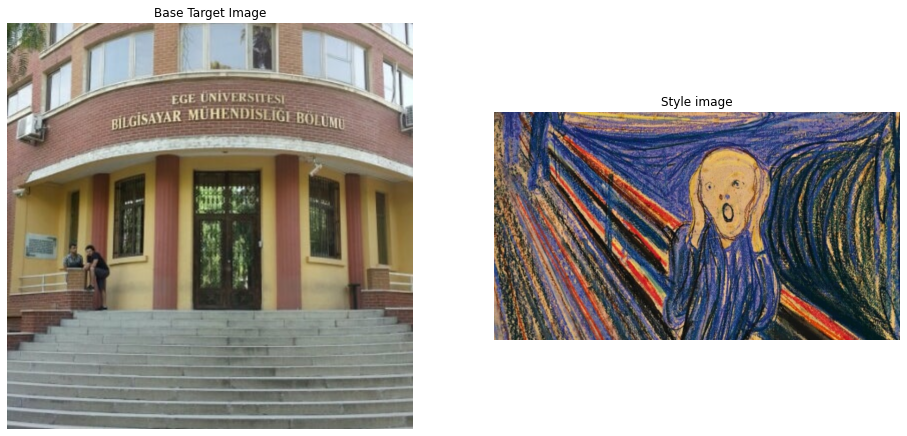

In [44]:
# Load images
content_img = load_image('img/content/egebilmuh.jpg')
style_img = load_image('img/style/scream.jpg')

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(content_img, axis=0))
plt.title('Base Target Image')
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(style_img, axis=0))
plt.title('Style image')
plt.axis("off")
plt.show()


In [45]:
# Load model
vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg_model.trainable = False
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [46]:
# Set style and content layers
content_layers = ['block4_conv2']
style_layers = ['block1_conv1', 
                'block2_conv1', 
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

# content_layers = ['block1_conv2',
#                   'block2_conv2',
#                   'block3_conv2']
# style_layers = ['block1_conv1',
#                 'block2_conv1',
#                 'block3_conv1', 
#                 'block4_conv1', 
#                 'block5_conv1']

In [47]:
# Create the model
def create_model(style_layers, content_layers):
    style_outputs = [vgg_model.get_layer(name).output for name in style_layers]
    content_outputs = [vgg_model.get_layer(name).output for name in content_layers]
    outputs = style_outputs + content_outputs
    model = tf.keras.Model(vgg_model.input, outputs)
    return model


In [48]:
# Get style and content outputs
model = create_model(style_layers, content_layers)
style_outputs = model(style_img * 255.0)[:len(style_layers)]
content_outputs = model(content_img * 255.0)[len(style_layers):]

In [49]:
# Calculate gram matrix
def gram_matrix(input_tensor):
    input_shape = tf.shape(input_tensor)
    reshaped_tensor = tf.reshape(input_tensor, [-1, input_shape[3]])
    transposed_tensor = tf.transpose(reshaped_tensor)
    gram_matrix = tf.matmul(transposed_tensor, reshaped_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return gram_matrix / num_locations

In [50]:
# https://www.tensorflow.org/tutorials/generative/style_transfer
# Create model with style and content properties
class SCModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(SCModel, self).__init__()
        self.vgg = create_model(style_layers, content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs = outputs[:self.num_style_layers]
        content_outputs = outputs[self.num_style_layers:]
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        return {'content': content_dict, 'style': style_dict}
    
# Get style and content attributes
style_content_model = SCModel(style_layers, content_layers)
style_targets = style_content_model(style_img)['style']
content_targets = style_content_model(content_img)['content']

In [51]:

# Calculate loss function
style_weight = .3
content_weight = .5
# Custom weights for different style layers
# style_weights = {'block1_conv1': .2,
#                  'block2_conv1': .2,
#                  'block3_conv1': .19,
#                  'block4_conv1': .24,
#                  'block5_conv1': .7}
# style_weights = {'block1_conv1': .3,
#                  'block2_conv1': .25,
#                  'block3_conv1': .15,
#                  'block4_conv1': .05,
#                  'block5_conv1': .05}
style_weights = {'block1_conv1': .5,
                 'block2_conv1': .45,
                 'block3_conv1': .3,
                 'block4_conv1': .2,
                 'block5_conv1': .2}

In [52]:
def total_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([
        tf.reduce_mean(tf.square(style_outputs[name] - style_targets[name]))
        for name in style_outputs.keys()
    ])
    style_loss *= style_weight / len(style_layers)

    content_loss = tf.add_n([
        tf.reduce_mean(tf.square(content_outputs[name] - content_targets[name]))
        for name in content_outputs.keys()
    ])
    content_loss *= content_weight / len(content_layers)

    loss = style_loss + content_loss
    return loss

In [53]:
# Define tf.Variable to optimize the image
generated_image = tf.Variable(content_img)

In [54]:
# Normalize pixel values from 0 to 1
def normalization(image):
    return tf.clip_by_value(image, clip_value_min=0., clip_value_max=1.)

In [55]:
# Determine the optimization algorithm
optimizer = tf.optimizers.Adam(learning_rate=.02, beta_1=.990, epsilon=0.1)

In [56]:
# Define training steps
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = style_content_model(image)
        loss = total_loss(outputs)

    gradients = tape.gradient(loss, image)
    optimizer.apply_gradients([(gradients, image)])
    image.assign(normalization(image))

Step: 0, Loss: 4797425152.0


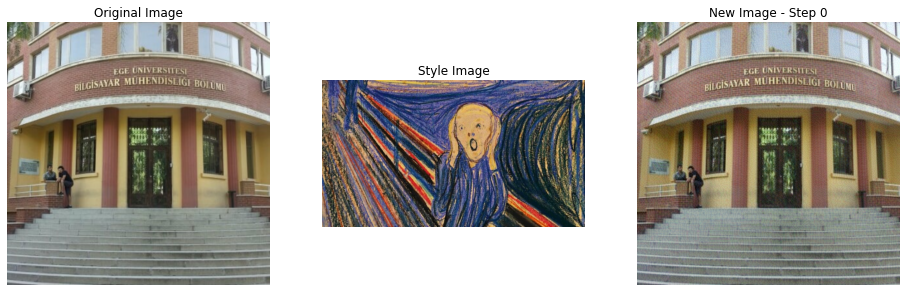

Step: 25, Loss: 366483392.0


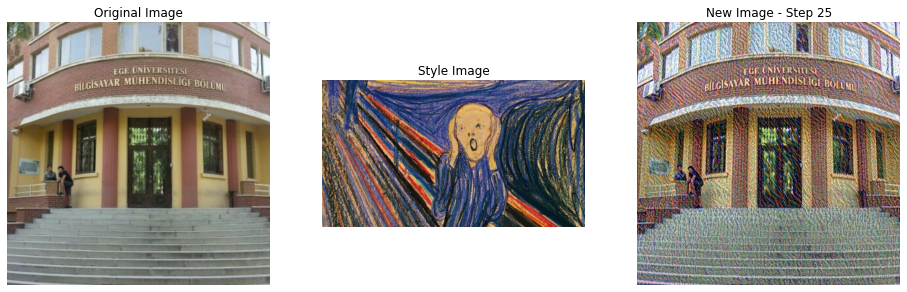

Step: 50, Loss: 212513552.0


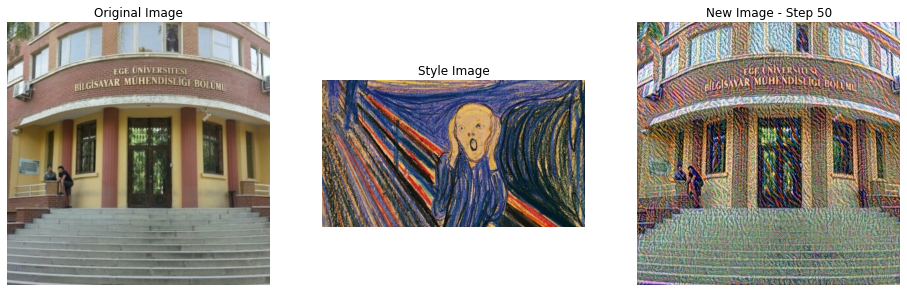

Step: 75, Loss: 133496552.0


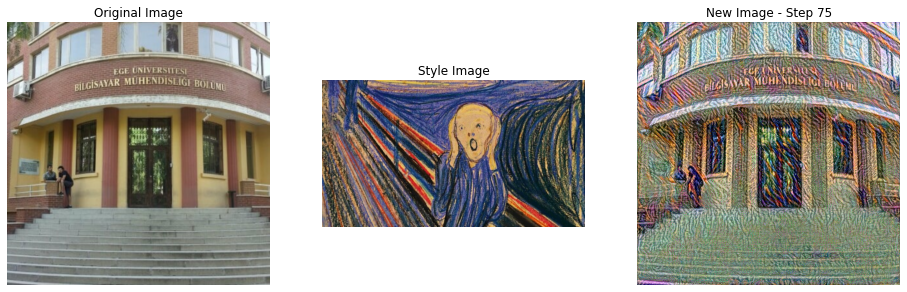

Step: 100, Loss: 89431832.0


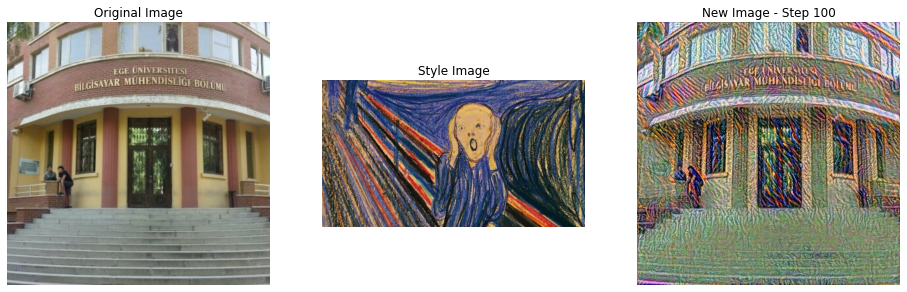

In [57]:
num_iterations = 100
for i in range(num_iterations + 1):
    train_step(generated_image)
    if i % 25 == 0:

        outputs = style_content_model(generated_image)
        loss = total_loss(outputs)
        print(f"Step: {i}, Loss: {loss}")

        plt.figure(figsize=(16, 16))

        plt.subplot(1, 3, 1)
        plt.imshow(np.squeeze(content_img, axis=0))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(np.squeeze(style_img, axis=0))
        plt.title('Style Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(np.squeeze(generated_image.read_value(), axis=0))
        plt.title('New Image - Step ' + str(i))
        plt.axis('off')

        plt.show()

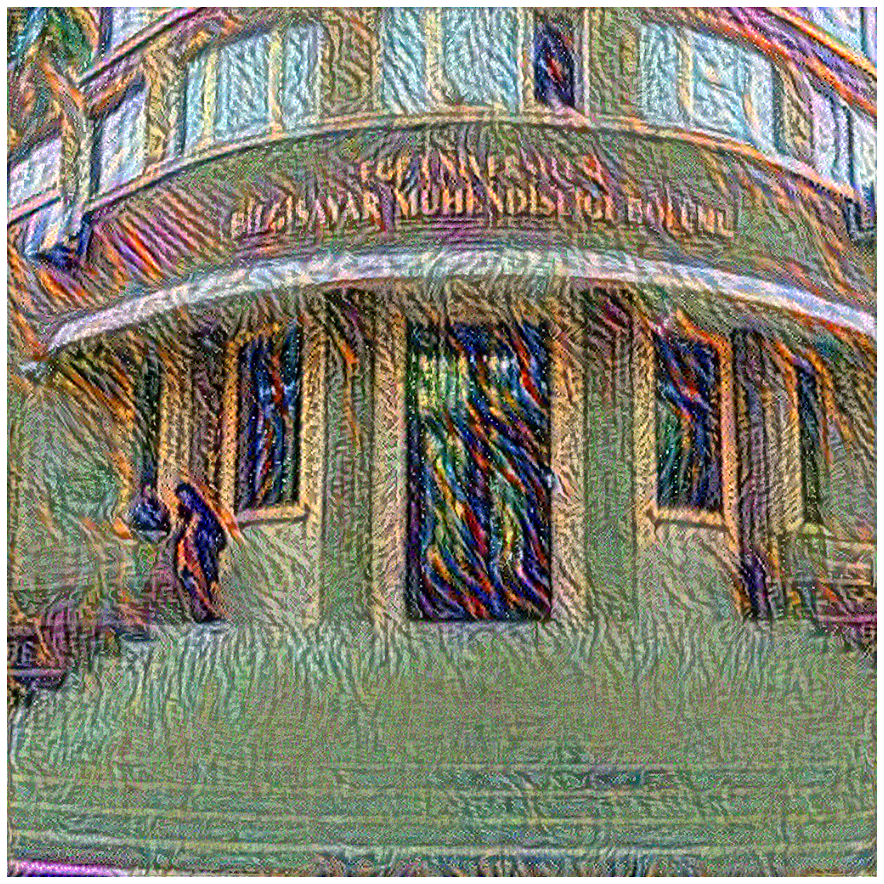

In [58]:
import random
plt.figure(figsize=(16,16))
plt.imshow(np.squeeze(generated_image.read_value(), axis=0))
plt.axis('off')
# plt.savefig(f'rendered/{random.randint(a=1,b=1e+5)}.png', bbox_inches='tight')
plt.show()